# Notebook for model development
This notebook should be used to develop the model submodules locally. Note, that model relevant changes have to be made in the model subclasses. Additional code in this document is only used to get a better understanding of the dataflow and debug some outputs.

## 1: Set up environment
### Install dependencies
This will use the automation `install_dependencies.sh` in order to install necessary packages. Additional packages for development can be installed afterwards.

In [3]:
! cd .. && bash automation/train_model/install_dependencies.sh

automation/train_model/install_dependencies.sh: line 1: python: command not found

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Import packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## 2: Get the data ready
In this step, the data will be imported and preprocessed.

### Download Dataset
The dataset has to be imported using the submodule `model/import_data.py`.

In [5]:
from model.import_data import import_data

x_train, y_train, x_test, y_test = import_data()

### Inspect dataset


Trainingsdaten: 
Anzahl: 60000
Durchschnittlicher Pixelwert: 33.32
Standardabweichung der Pixelwerte: 78.57
Höchster Pixelwert: 255.00
Niedrigster Pixelwert: 0.00
Bildgröße (Höhe x Breite): 28 x 28
Anzahl der Klassen: 10


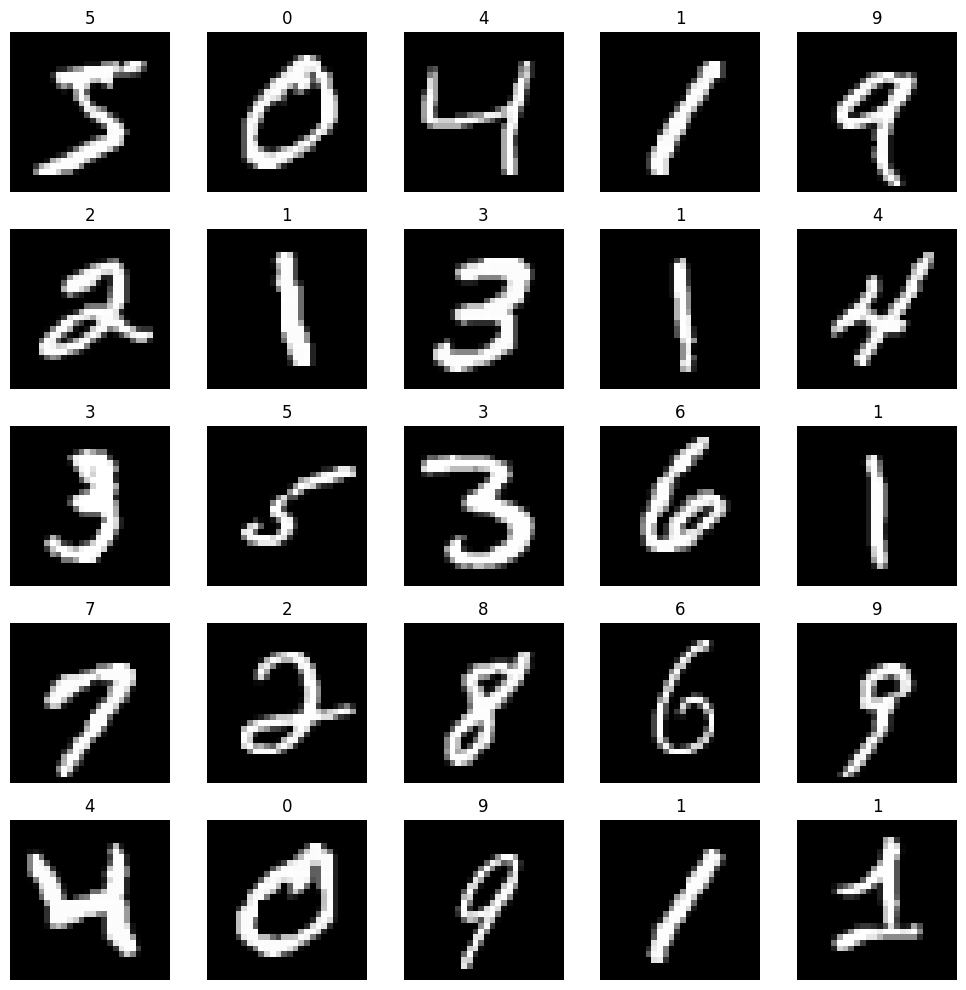


Testdaten: 
Anzahl: 10000
Durchschnittlicher Pixelwert: 33.79
Standardabweichung der Pixelwerte: 79.17
Höchster Pixelwert: 255.00
Niedrigster Pixelwert: 0.00
Bildgröße (Höhe x Breite): 28 x 28
Anzahl der Klassen: 10


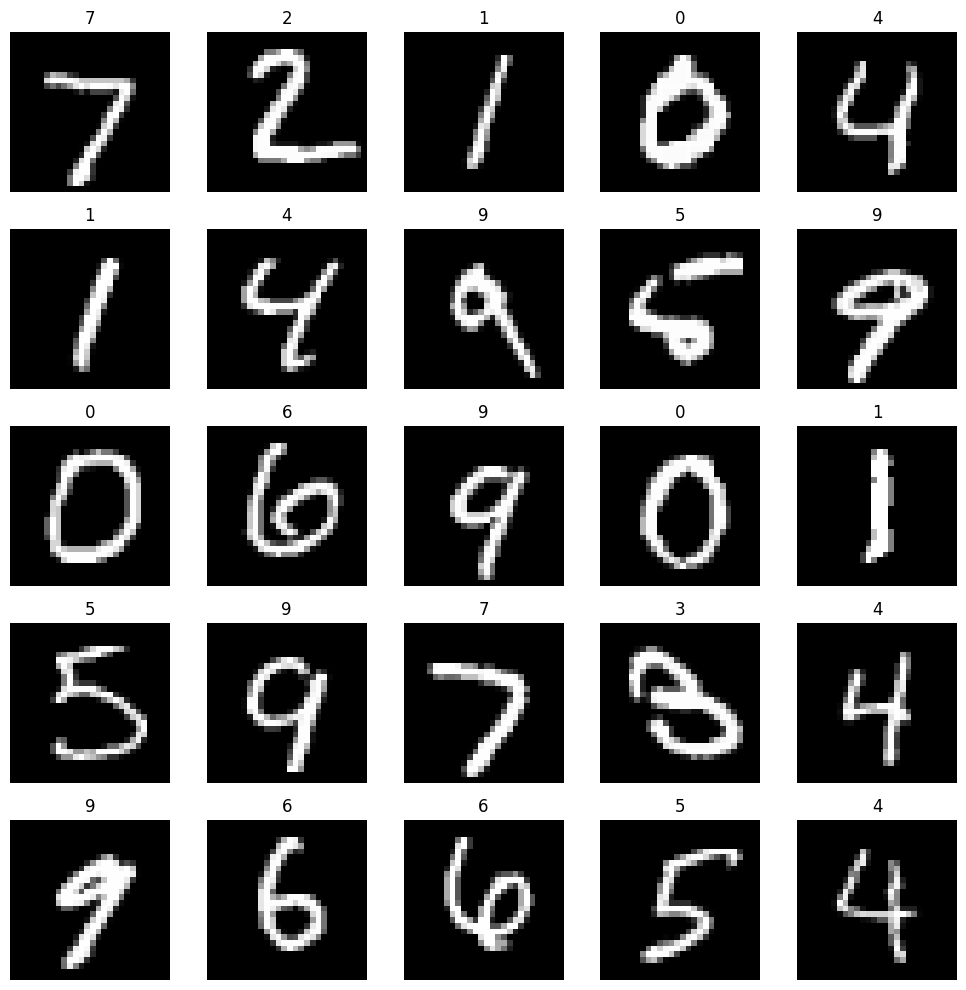

In [6]:
# Training set:
# Calc mean and std of pixel values
print("\nTrainingsdaten: ")
mean = np.mean(x_train)
std = np.std(x_train)
max = np.max(x_train)
min = np.min(x_train)
print(f"Anzahl: {x_train.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {x_train.shape[1]} x {x_train.shape[2]}")
print(f"Anzahl der Klassen: {len(np.unique(y_train))}")

# Show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"{y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Test set:
# Calc mean and std of pixel values
print("\nTestdaten: ")
mean = np.mean(x_test)
std = np.std(x_test)
max = np.max(x_test)
min = np.min(x_test)
print(f"Anzahl: {x_test.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {x_test.shape[1]} x {x_test.shape[2]}")
print(f"Anzahl der Klassen: {len(np.unique(y_test))}")

# Show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"{y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Preprocess dataset
The dataset is preprocessed using the submodule `model/preprocess_data.py`.

In [7]:
from model.preprocess_data import preprocess_data

x_train, x_test = preprocess_data(x_train, x_test)


Trainingsdaten: 
Anzahl: 60000
Durchschnittlicher Pixelwert: 0.13
Standardabweichung der Pixelwerte: 0.31
Höchster Pixelwert: 1.00
Niedrigster Pixelwert: 0.00
Bildgröße (Höhe x Breite): 28 x 28
Anzahl der Klassen: 10


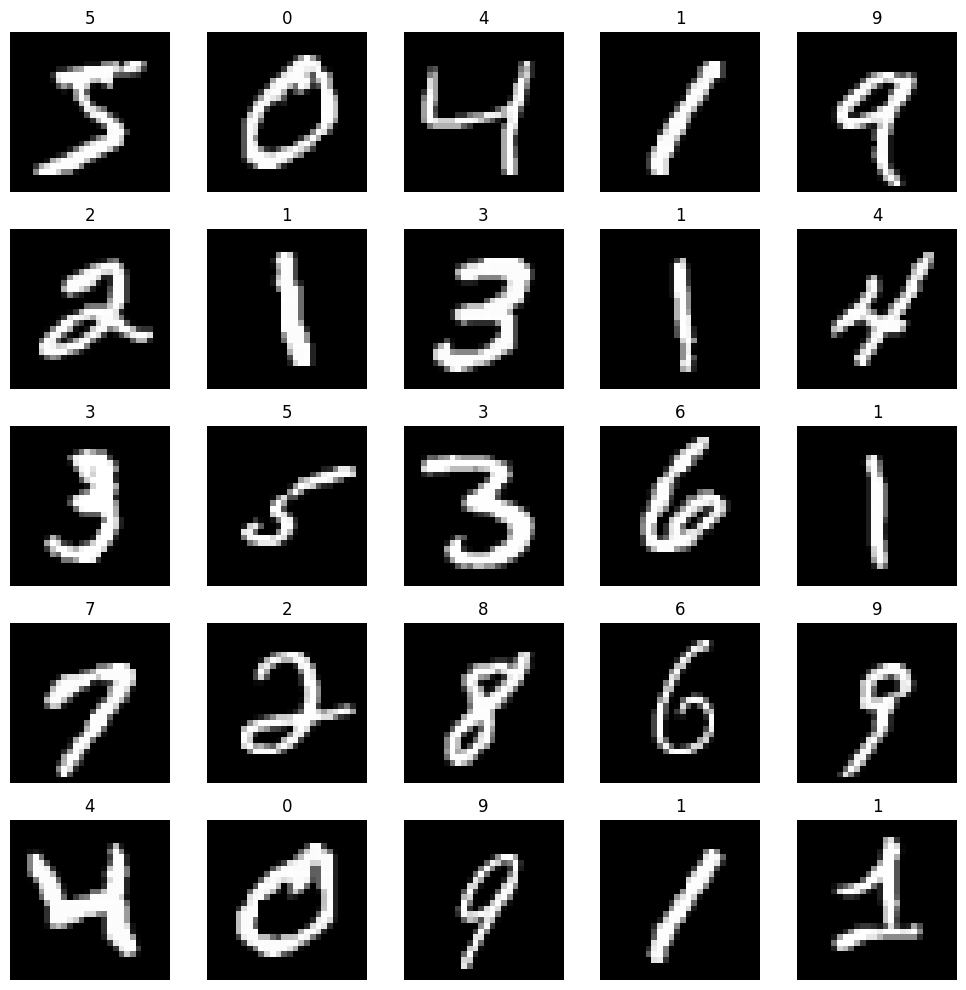


Testdaten: 
Anzahl: 10000
Durchschnittlicher Pixelwert: 0.13
Standardabweichung der Pixelwerte: 0.31
Höchster Pixelwert: 1.00
Niedrigster Pixelwert: 0.00
Bildgröße (Höhe x Breite): 28 x 28
Anzahl der Klassen: 10


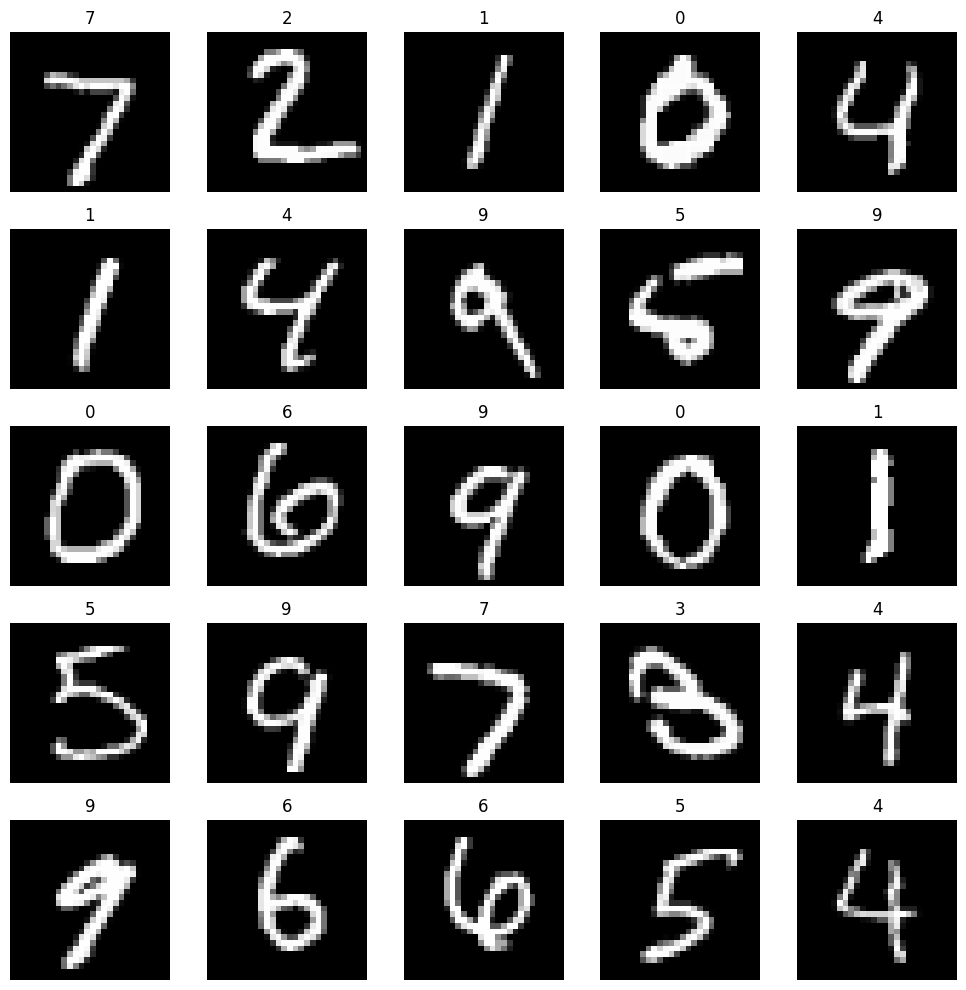

In [8]:
# Training set:
# Calc mean and std of pixel values
print("\nTrainingsdaten: ")
mean = np.mean(x_train)
std = np.std(x_train)
max = np.max(x_train)
min = np.min(x_train)
print(f"Anzahl: {x_train.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {x_train.shape[1]} x {x_train.shape[2]}")
print(f"Anzahl der Klassen: {len(np.unique(y_train))}")

# Show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"{y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Test set:
# Calc mean and std of pixel values
print("\nTestdaten: ")
mean = np.mean(x_test)
std = np.std(x_test)
max = np.max(x_test)
min = np.min(x_test)
print(f"Anzahl: {x_test.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {x_test.shape[1]} x {x_test.shape[2]}")
print(f"Anzahl der Klassen: {len(np.unique(y_test))}")

# Show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"{y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3: Model

### Create model
The model is created using `model/create_model.py`

In [9]:
from model.create_model import create_model

model = create_model()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Inspect model

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

### Model training
The model is trained using `model_fit_model.py`
This should ideally be done using the workflow.

In [17]:
from model.fit_model import fit_model

history = fit_model(model, x_train, y_train)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9864 - loss: 0.0426
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9880 - loss: 0.0373
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9874 - loss: 0.0371
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9894 - loss: 0.0324
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9894 - loss: 0.0316


Final loss: 0.0326
Final accuracy: 0.9890


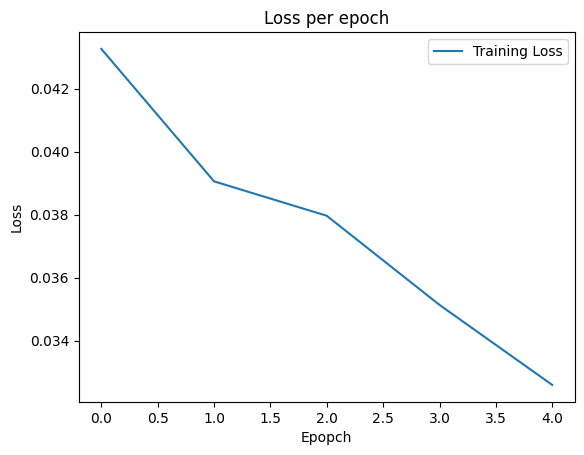

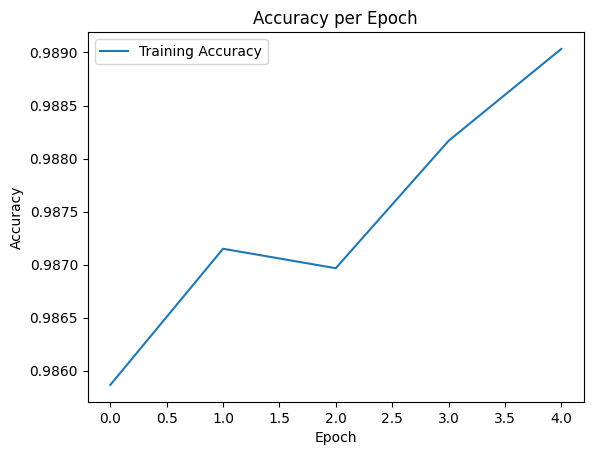

In [22]:
print(f"Final loss: {history.history['loss'][-1]:.4f}")
print(f"Final accuracy: {history.history['accuracy'][-1]:.4f}")

# Trainings- und Validierungsverlust
plt.figure(1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per epoch')
plt.xlabel('Epopch')
plt.ylabel('Loss')
plt.legend()

# Genauigkeit (Accuracy) plotten
plt.figure(2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluate model
The model is evaluated using `model/evaluate_model.py`

In [23]:
from model.evaluate_model import evaluate_model

evaluate_model(model, x_test, y_test)

313/313 - 0s - 647us/step - accuracy: 0.9794 - loss: 0.0765

Test accuracy: 0.9793999791145325


### Save model

In [25]:
model.save('model.keras')